In [33]:
#Import necessary modules
import pandas as pd
import PySimpleGUI as sg
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pingouin as pg
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [34]:
#Popup window to select .csv file for analysis
sg.theme('LightBlue2')
File = sg.popup_get_file('Please select the .csv file for analyzing',
                         keep_on_top = True)
data = pd.read_csv(File, header = 0, keep_default_na = False)
#Keep na so athlete NA does not become NaN

In [35]:
#Sorting the data by athlete and trial in ascending order
data.sort_values(['Athlete', 'Trial'],
                 inplace = True,
                 ascending = [True, True])

#Create New DataFrame with max and average velocities for each athlete
NewData = pd.DataFrame()
NewData[['Radar_Max', 'Radar_Avg']] = data.groupby('Athlete')['Radar'].aggregate([max, np.mean])
NewData[['TimingGate_Max', 'TimingGate_Avg']] = data.groupby('Athlete')['TimingGate'].aggregate([max, np.mean])
NewData[['Optojump_Max', 'Optojump_Avg']] = data.groupby('Athlete')['Optojump'].aggregate([max, np.mean])
NewData.reset_index(inplace = True)


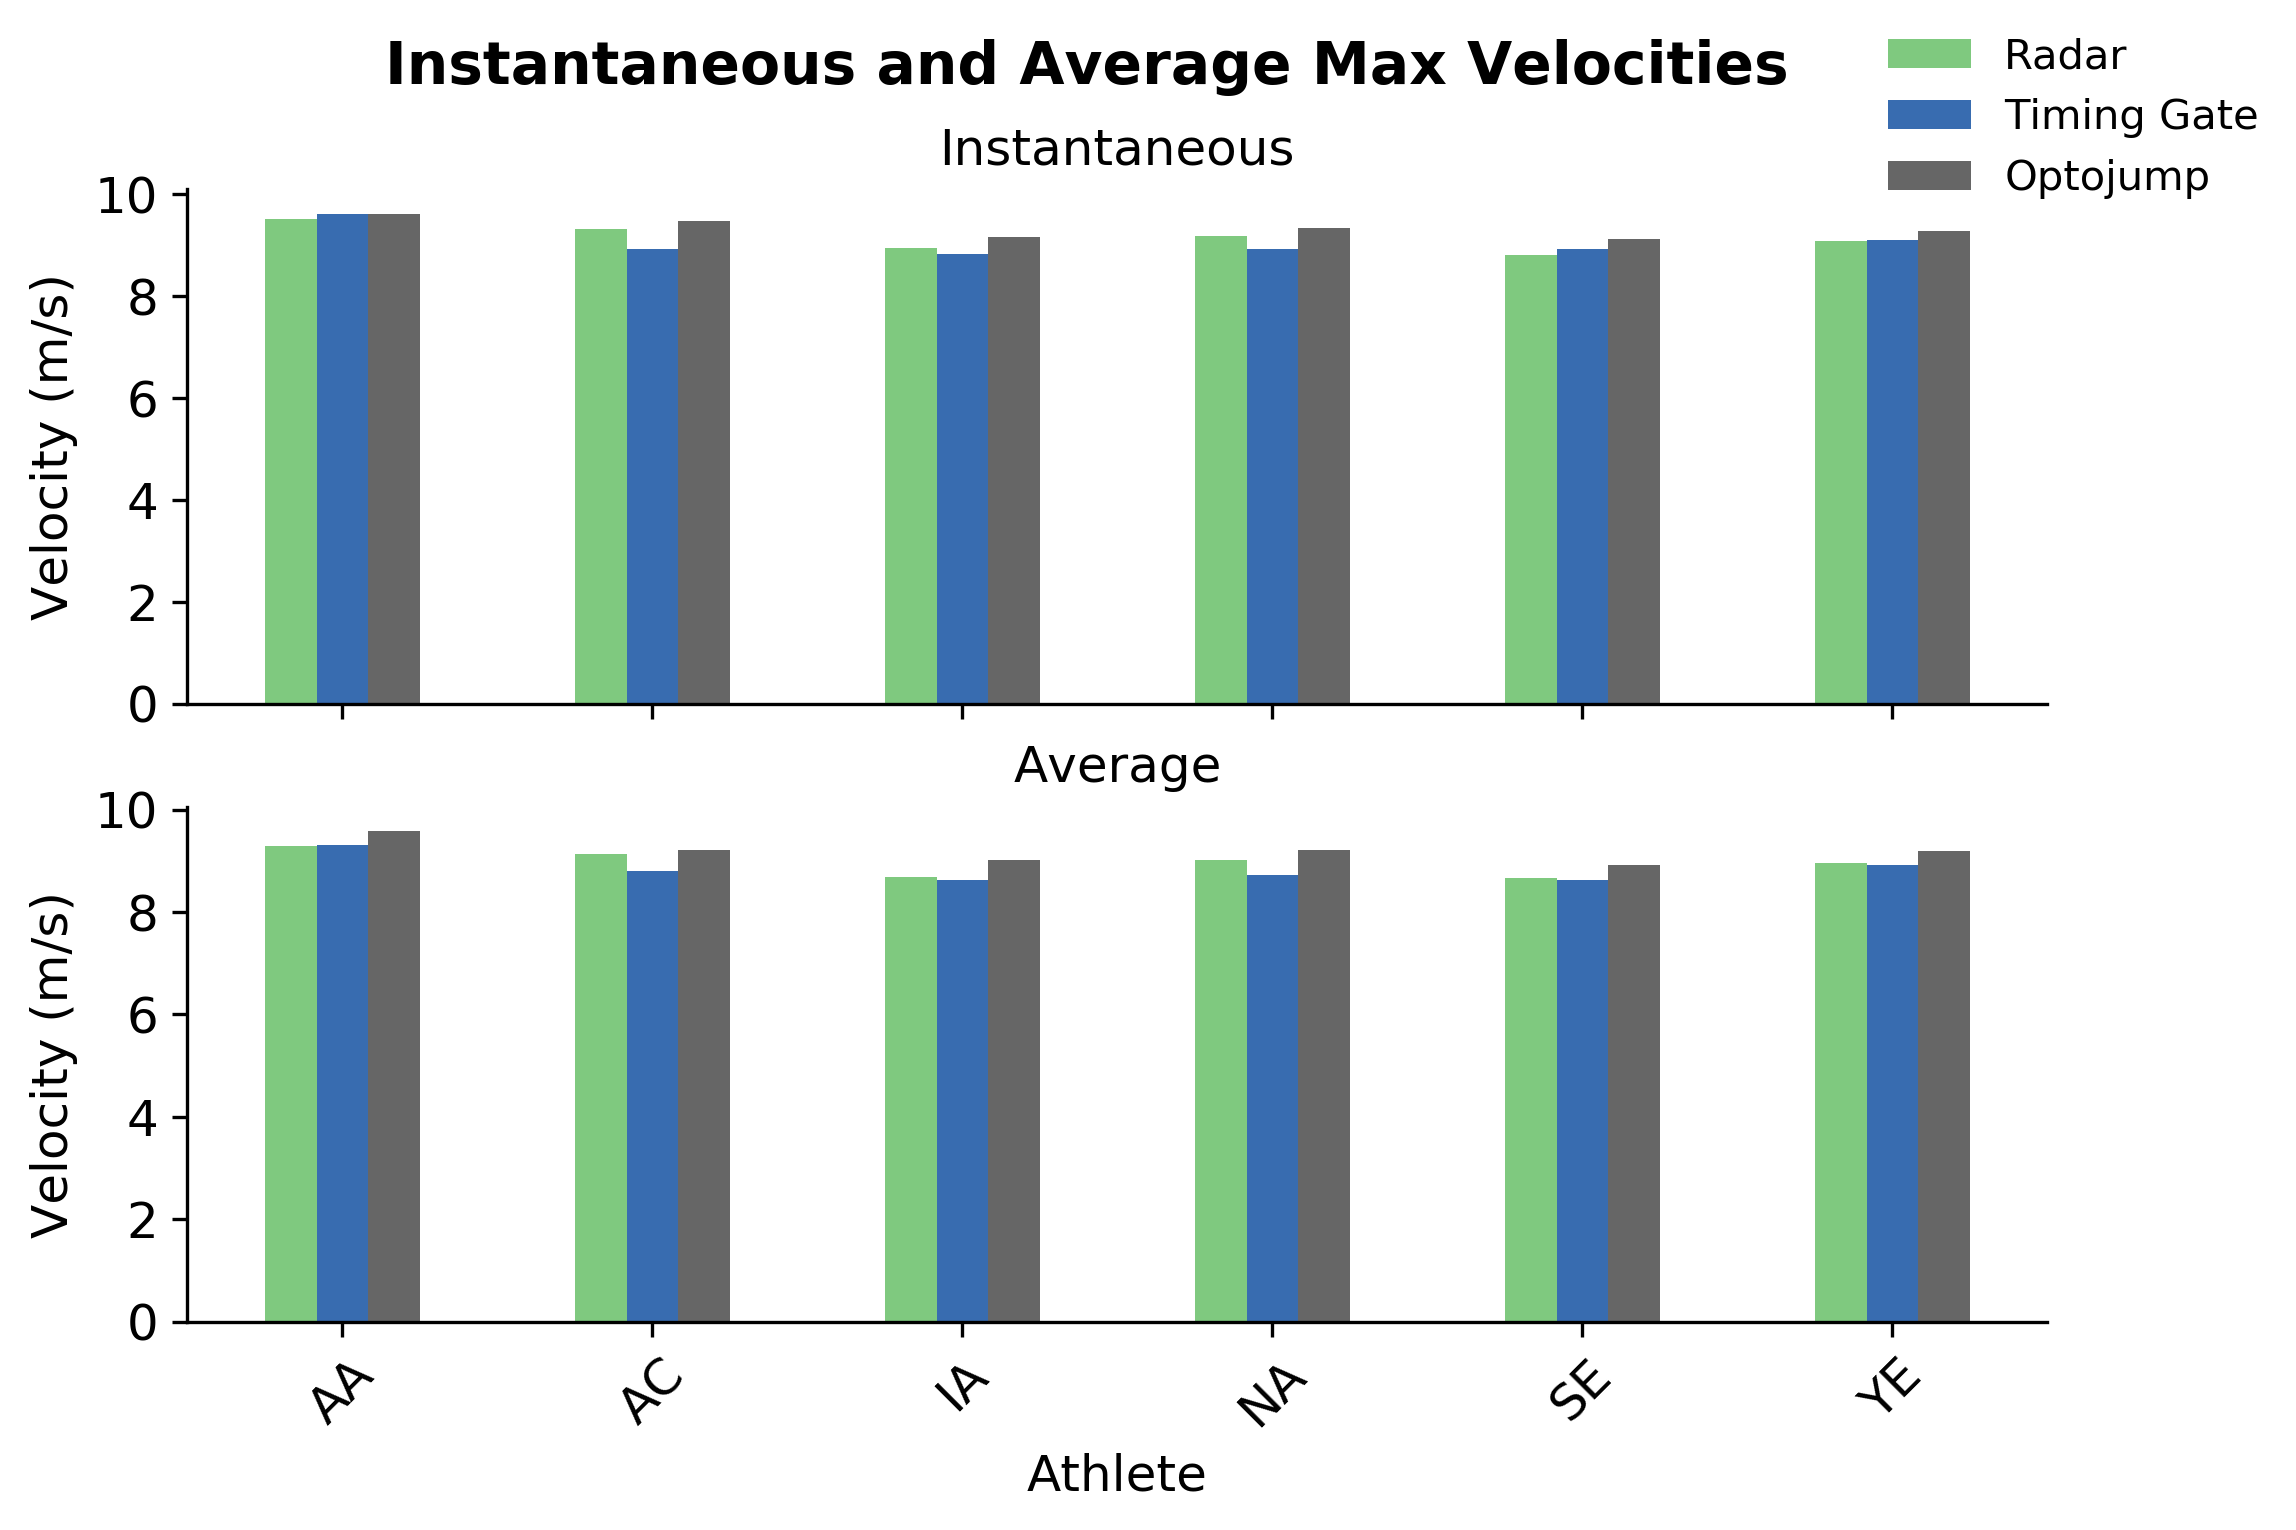

In [36]:
#Visualizing max and average data in bar plots

fig1, axes = plt.subplots(2, figsize =(8,5), dpi = 300)
#Set figure size to 8x5 and dpi to 300

fig1.suptitle('Instantaneous and Average Max Velocities',
              fontweight = "bold", 
              size = 14)
#Set title for subplot figure

NewData.plot(x = "Athlete",
             y = ["Radar_Max", "TimingGate_Max", "Optojump_Max"],
             ax = axes[0],
             kind = "bar", 
             title = 'Instantaneous', 
             rot = 45,
             legend = False, 
             cmap = "Accent", 
             fontsize = 12)
#Plot max velocity data

NewData.plot(x = "Athlete",
             y = ["Radar_Avg", "TimingGate_Avg", "Optojump_Avg"],
             ax = axes[1],
             kind = "bar",
             title = 'Average',
             rot = 45,
             legend = False, 
             cmap = "Accent", 
             fontsize = 12)
#Plot average velocity data

fig1.legend(['Radar', 'Timing Gate', 'Optojump'],
            loc = 'upper right', 
            frameon = False,
            fontsize = 10)
#Set legend location to upper right with no frame and fontsize of 10

for ax in axes.flat:
    ax.set_ylabel('Velocity (m/s)', fontsize = 12)
    ax.set_xlabel('Athlete', fontsize = 12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.title.set_size(12)
for ax in axes.flat:
    ax.label_outer()
# Label the axes 
# remove top and right graph spines
# specifying font sizes
# Set axes labels on outer edge of figure

plt.show()

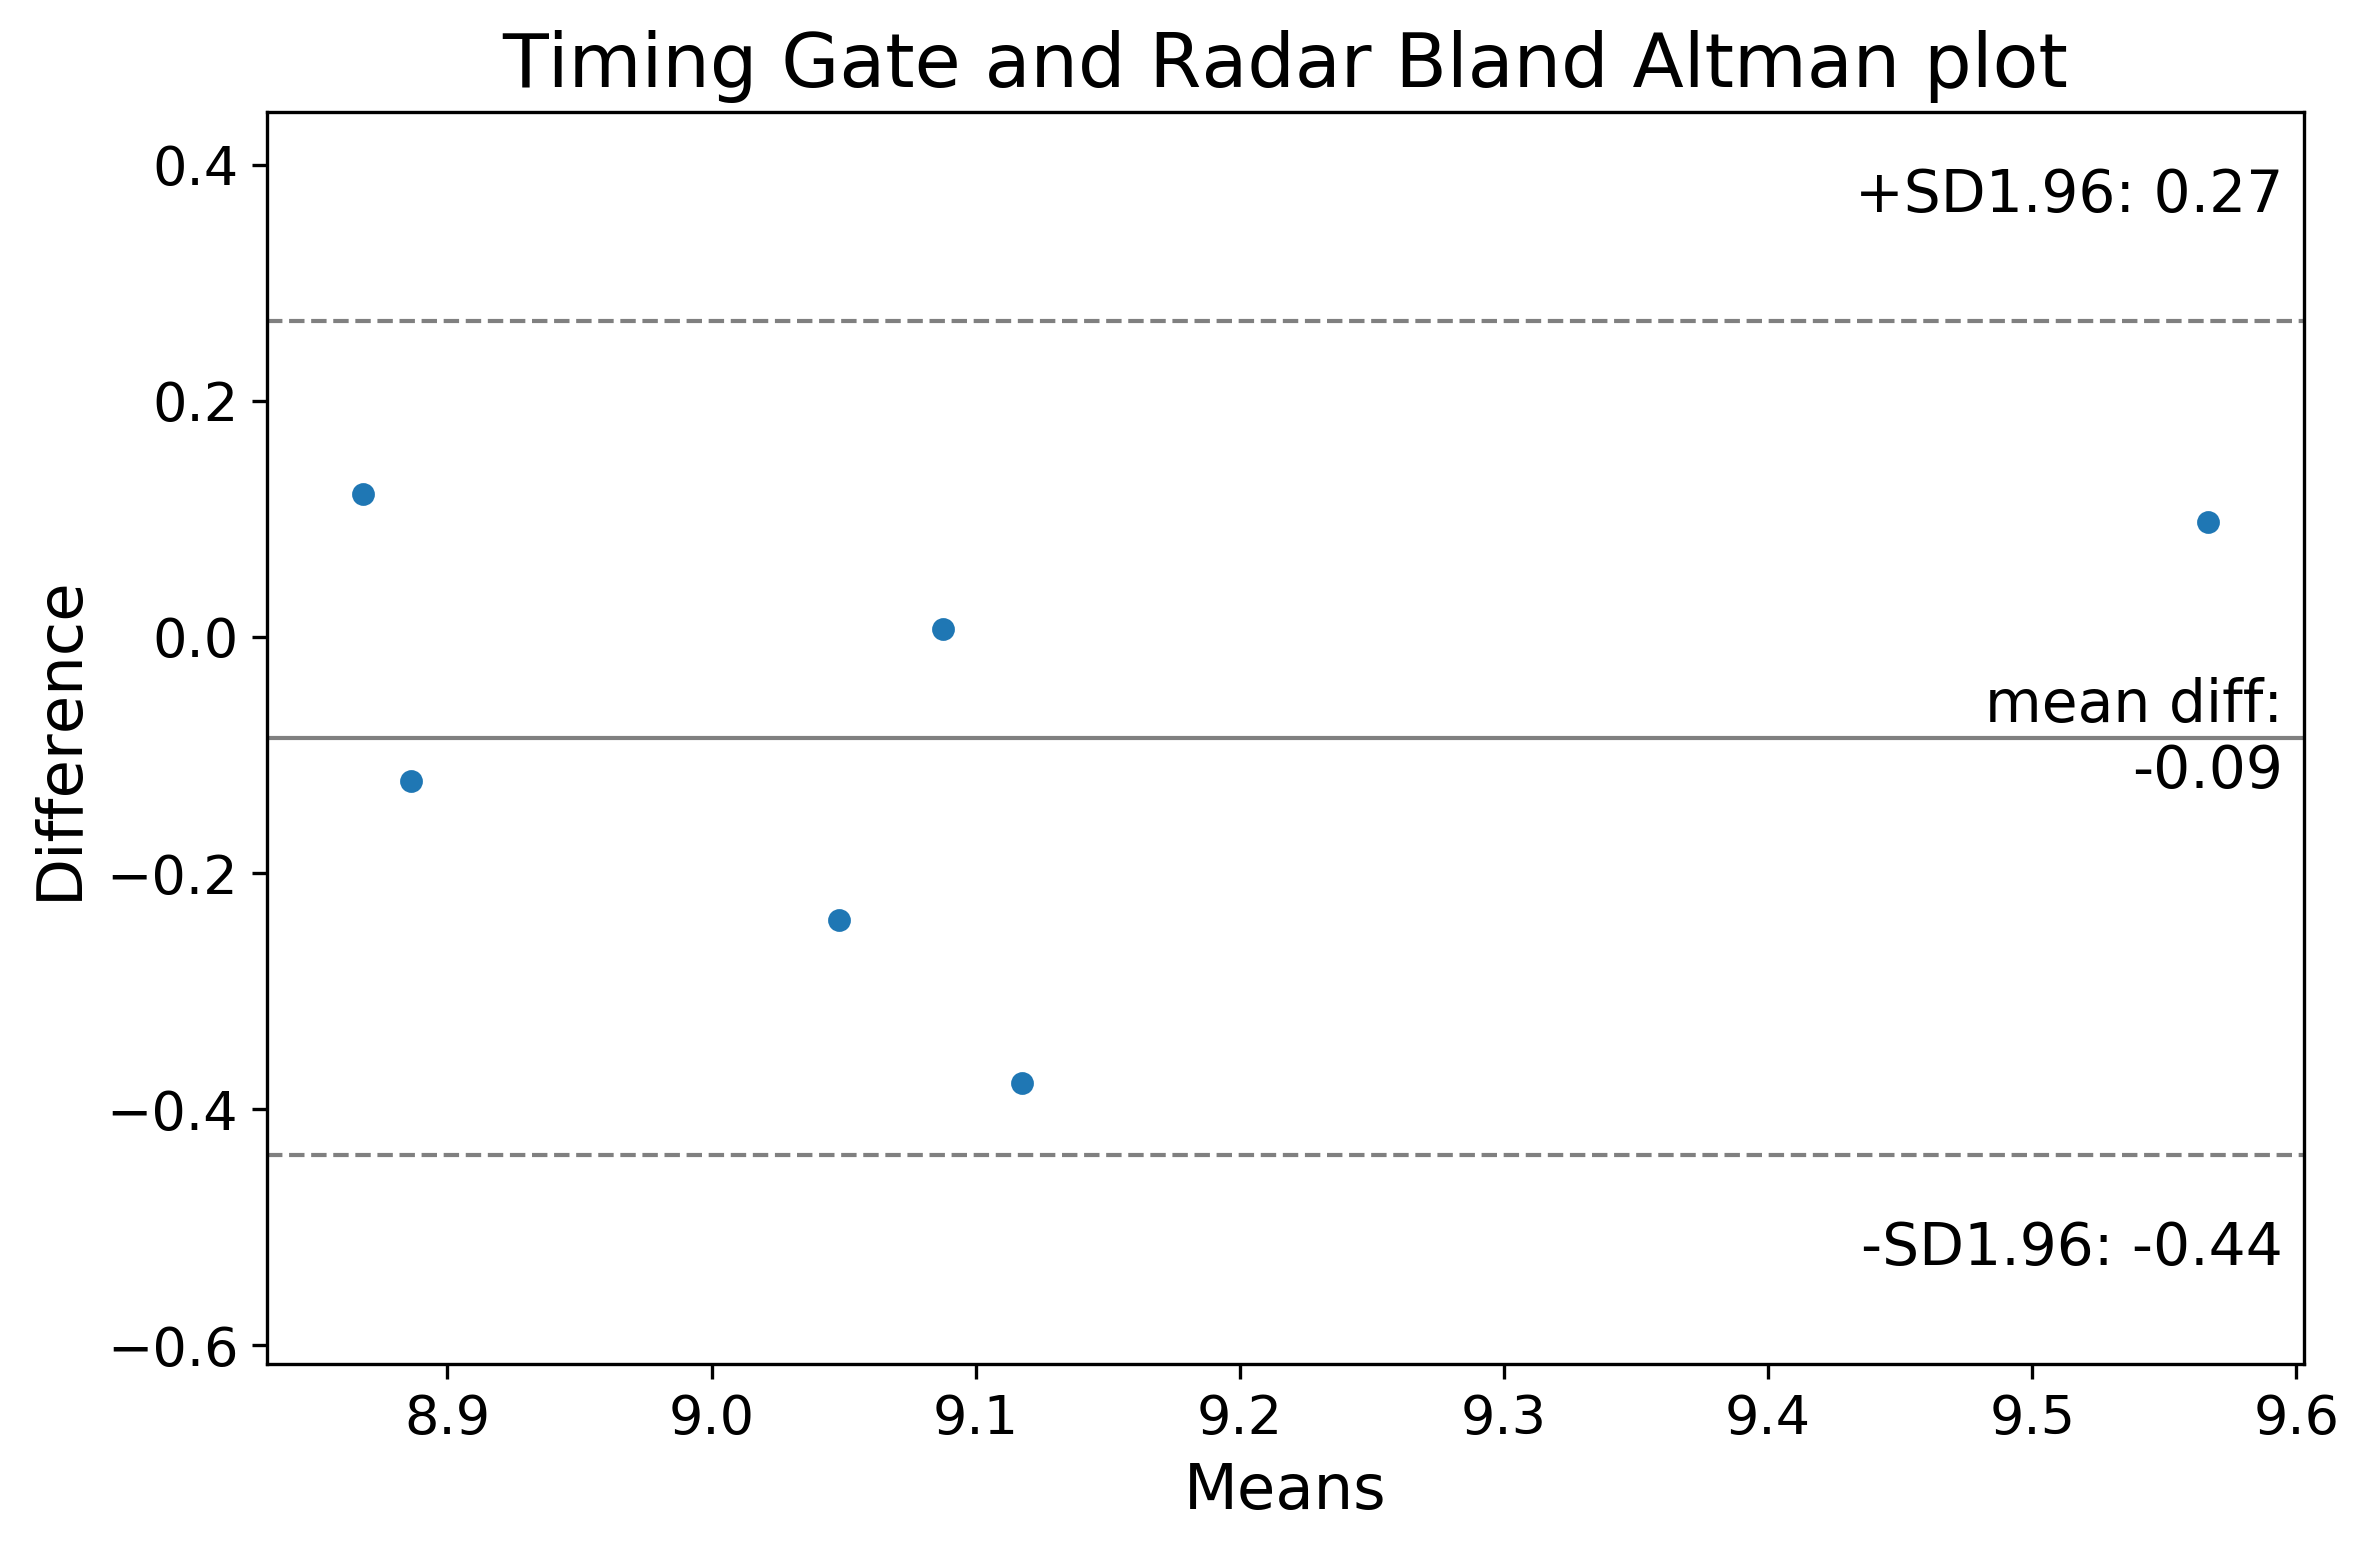

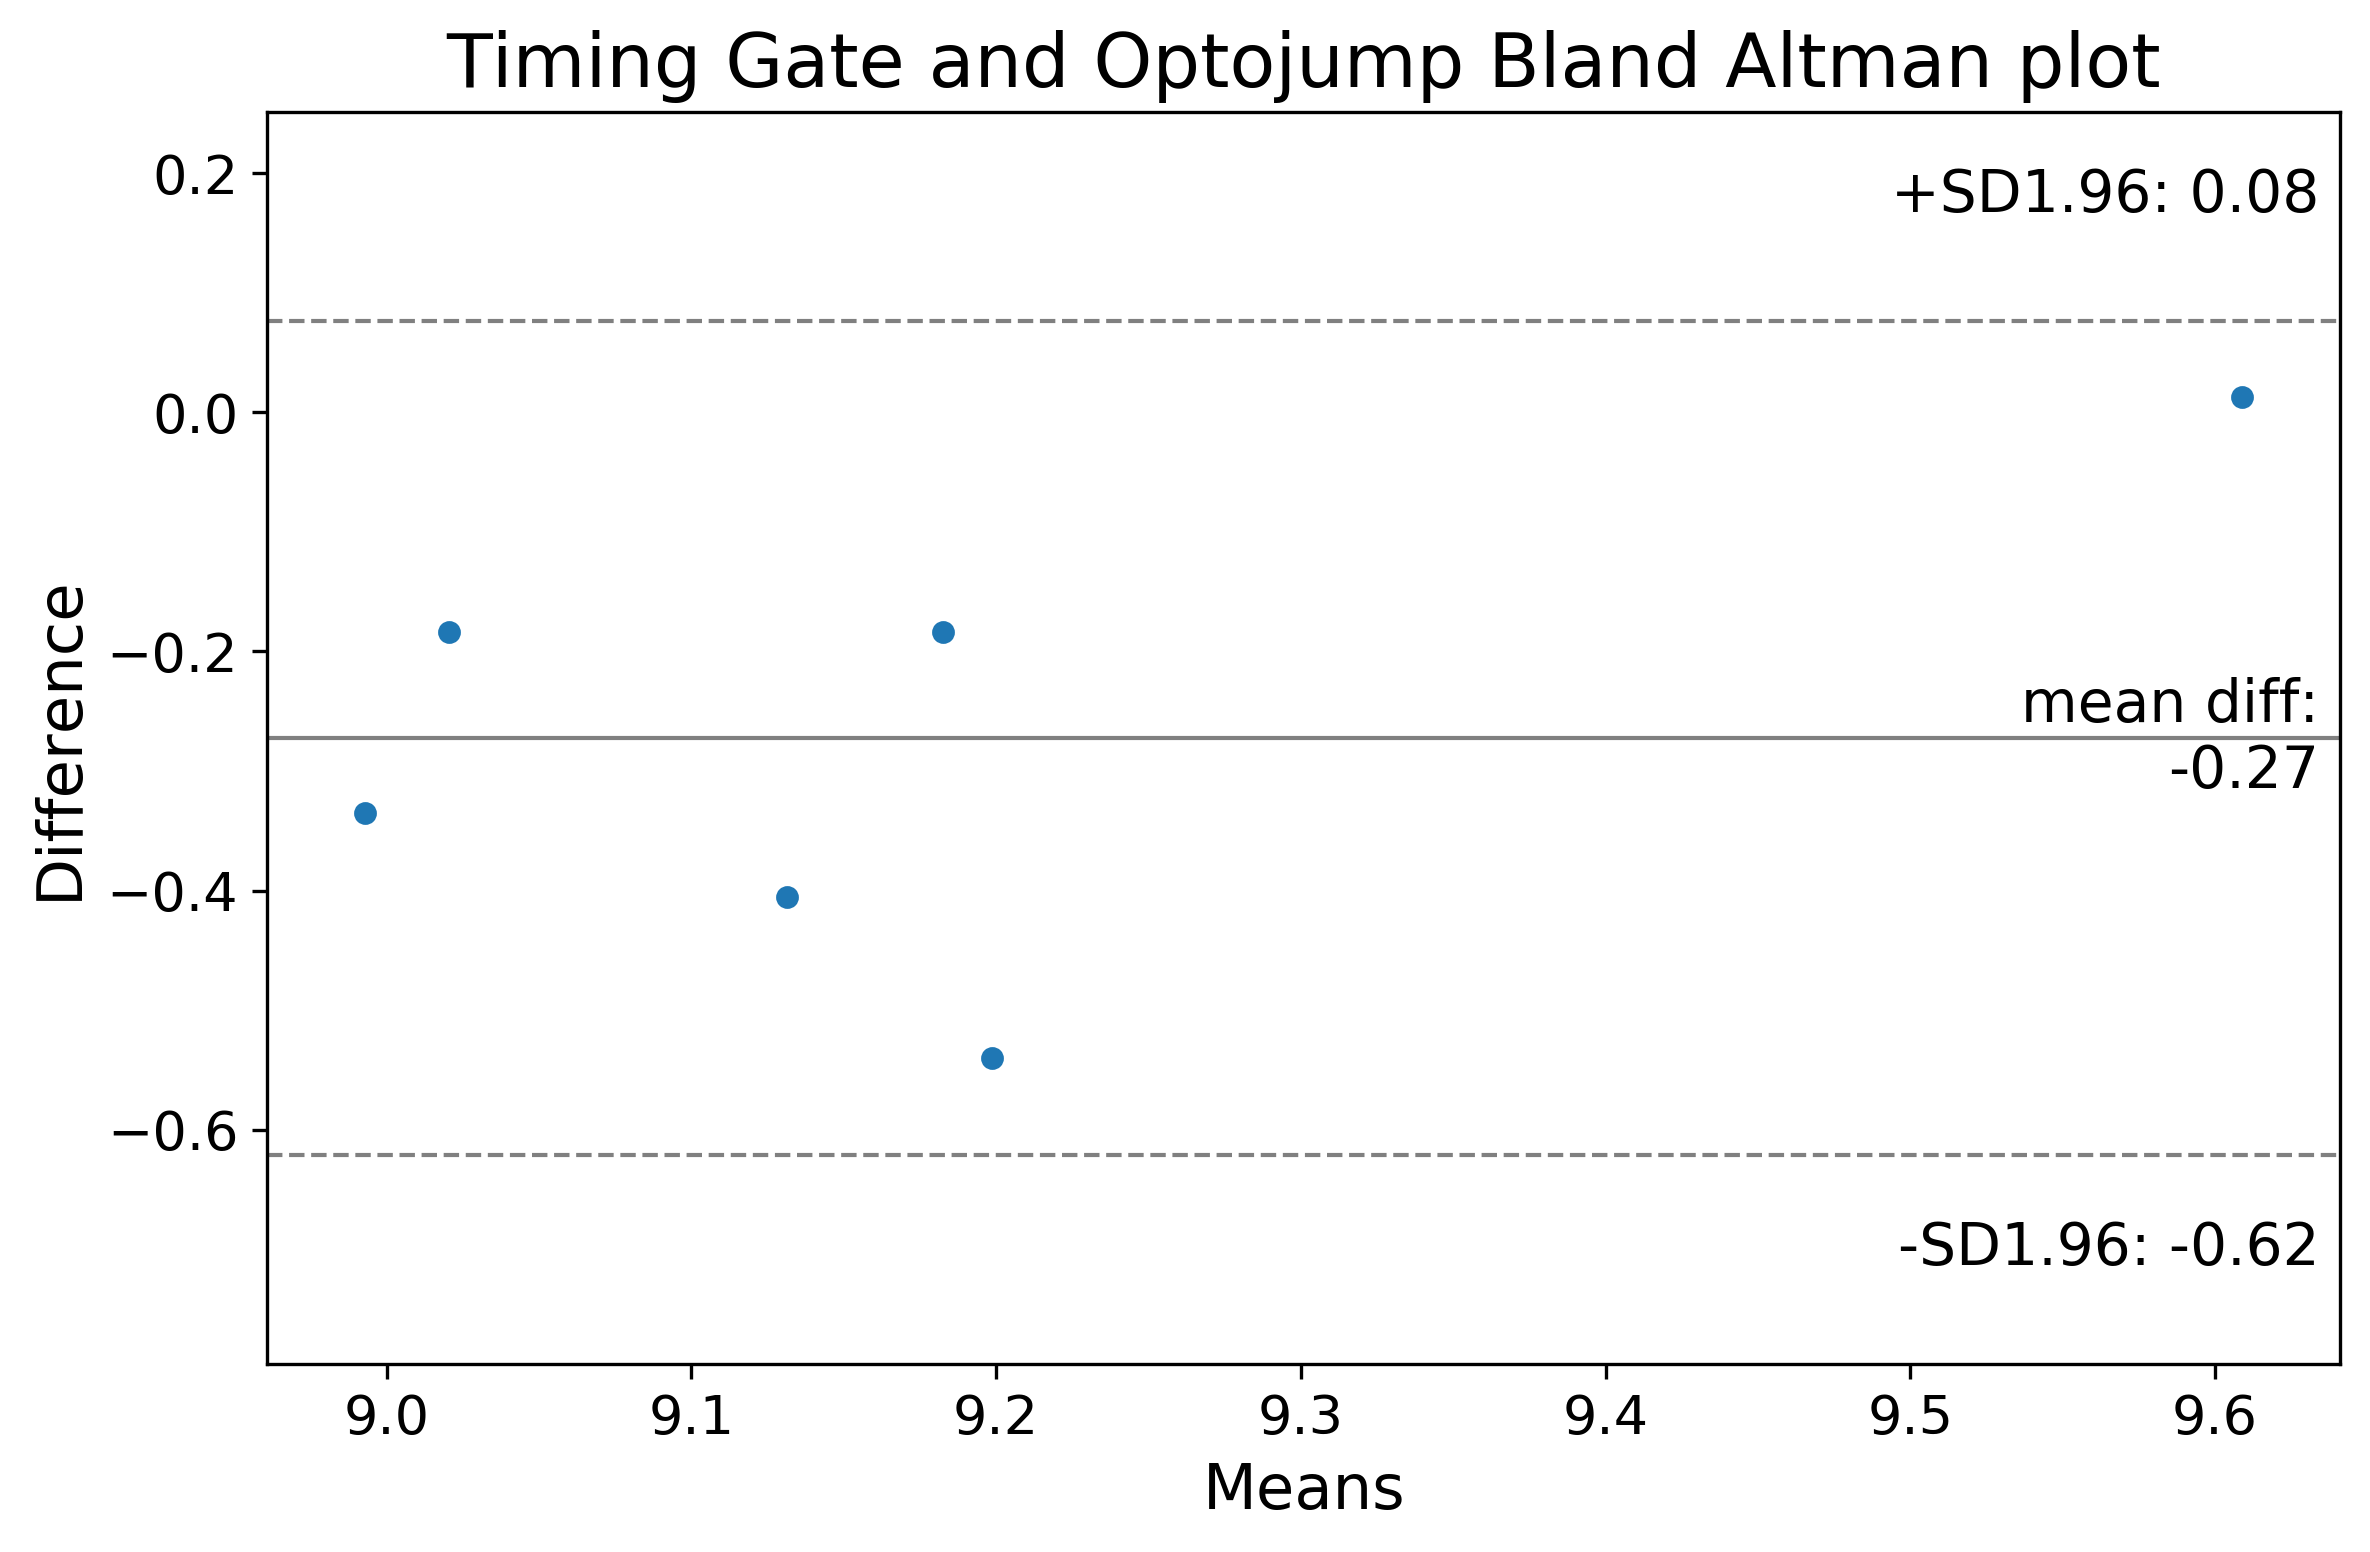

In [37]:
#Bland Altman plots

fig2, ax = plt.subplots(1, figsize = (8,5), dpi = 300)
#Set figure size to 8x5 and dpi to 300

sm.graphics.mean_diff_plot(NewData['TimingGate_Max'],
                           NewData['Radar_Max'],
                           ax = ax)
plt.title('Timing Gate and Radar Bland Altman plot', fontsize = 18)
plt.show()
#Plot for TimingGate and Radar 

fig3, ax = plt.subplots(1, figsize = (8,5), dpi = 300)
#Set figure size to 8X5 and dpi to 300

sm.graphics.mean_diff_plot(NewData['TimingGate_Max'], 
                           NewData['Optojump_Max'],
                           ax = ax)
plt.title('Timing Gate and Optojump Bland Altman plot', fontsize = 18)
plt.show()  
#Plot for TimingGate and Optojump

               Intraclass correlation data reorganization

                  Two new Pandas DataFrames are created:
               one for Timing Gate and Radar Max velocities; 
             another for Timing Gate and Optojump max velocities 
    
    df.melt is used to arrage the data by athlete, variable, and values
                               For example: 

                      Athlete    Variable    Value 
                        AA     Timing Gate    9.62
                        AA        Radar       9.52

In [38]:
ICCRadar = pd.DataFrame()
ICCRadar['Athlete'] = NewData['Athlete']
ICCRadar['TimingGate'] = NewData['TimingGate_Max']
ICCRadar['Radar'] = NewData['Radar_Max']
ICCRadar = ICCRadar.melt(id_vars = ['Athlete'])
ICCRadar.sort_values('Athlete', inplace = True, ascending = True)
#Dataframe for Timing Gate and Radar

ICCOpto = pd.DataFrame()
ICCOpto['Athlete'] = NewData['Athlete']
ICCOpto['TimingGate'] = NewData['TimingGate_Max']
ICCOpto['Optojump'] = NewData['Optojump_Max']
ICCOpto = ICCOpto.melt(id_vars = ['Athlete'])
ICCOpto.sort_values('Athlete', inplace = True, ascending = True)
#DataFrame for Timing Gate and Optojump

In [39]:
#Calculating ICC values

iccRadar = pg.intraclass_corr(data = ICCRadar,
                              targets = 'variable',
                              raters = 'Athlete',
                              ratings = 'value'  )
#ICC dataframe for Timing Gate and Radar

iccOpto = pg.intraclass_corr(data = ICCOpto,
                             targets = 'variable',
                             raters = 'Athlete',
                             ratings = 'value'  )
#ICC dataframe for Timing Gate and Optojump

iccRadar = iccRadar.round(decimals = 2)
iccOpto = iccOpto.round(decimals = 2)
iccRadar = iccRadar.drop("Description", axis = 1)
iccOpto = iccOpto.drop("Description", axis = 1)
#Rounding numeric values to 2 decimal places
#Dropping the description column to get rid of clutter

In [40]:
#Creating ICC tables 

table1 = ff.create_table(iccRadar)
#Creating table of ICC values for Timing Gate and Radar

table2 = ff.create_table(iccOpto)
#Creating table of ICC values for Timing Gate and Optojump

fig = make_subplots(rows = 2, 
                    cols = 1,
                    print_grid = True,
                    vertical_spacing = 0.085,
                    subplot_titles = ('ICC values for Timing Gates and Radar', 'ICC values for Timing Gate and Optojump'))
#Set figure with 2 rows and 1 column that shows
#Specify the space between plots (0.085) and individual table titles

fig.add_trace(table1.data[0], 1, 1)
#Add table 1 to figure

fig.add_trace(table2.data[0], 2, 1)
#Add table 2 to figure

fig.layout.xaxis.update(table1.layout.xaxis)
fig.layout.yaxis.update(table1.layout.yaxis)
fig.layout.xaxis2.update(table2.layout.xaxis)
fig.layout.yaxis2.update(table2.layout.yaxis)
#Update x and y axis layout for both tables

for k in range(len(table2.layout.annotations)):
    table2.layout.annotations[k].update(xref = 'x2', yref = 'y2')
#Update table layout annotations to specify difference between x,y and x2,y2

all_annots = fig.layout.annotations+table1.layout.annotations + table2.layout.annotations
fig.layout.annotations = all_annots
#Updating all changes to table annotations to figure annotations

fig.layout.update(width=800,
                  height=600,
                  margin=dict(t=100, l=50, r=50, b=50));
#Set figure size to 800x600 and specific margins

iplot(fig)

This is the format of your plot grid:
[ (1,1) x,y   ]
[ (2,1) x2,y2 ]



In [41]:
#Save images and files

selectfolder = sg.popup_get_folder('Select a folder to save all plots and files', keep_on_top = True)
#Select folder to save files to

fig1.savefig(selectfolder + '/Velocity bar plot.tiff', bbox_inches = 'tight')
#Save velocity bar plots as .tiff 

fig2.savefig(selectfolder + '/Radar bland altman plot.tiff',  bbox_inches='tight')
#Save Timing Gate and Radar Bland Altman plot as .tiff

fig3.savefig(selectfolder + '/Opto jump bland altman plot.tiff', bbox_inches='tight') 
#Save Timing Gate and Optojump Bland Altman plot as .tiff

fig.write_html(selectfolder + "/ICC tables.html")
#Save ICC tables as .html 

iccRadar.set_index('Type', inplace = True)
iccOpto.set_index('Type', inplace = True)
NewData.set_index('Athlete', inplace = True)
#Reset indices of dataframes for cleaner look in excel document

with pd.ExcelWriter(selectfolder + '/Analyzed Validation Data.xlsx') as writer:
    iccRadar.to_excel(writer, sheet_name = 'ICC Radar data')
    iccOpto.to_excel(writer, sheet_name = 'ICC Opto data')
    NewData.to_excel(writer, sheet_name = 'Max velocities')
#Adding ICC table data and velocity data to separate sheets in a .xlsx file

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'